# Forward-Backward to Solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the forward backward framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the forward backward algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).

* Combettes, P. L. and Wajs, V. <i>Signal recovery by proximal forward-backwardsplitting</i>. Multiscale Modeling and Simulation (MMS), (4):1168–1200 (2005). [https://www.ljll.math.upmc.fr/~plc/mms1.pdf](https://www.ljll.math.upmc.fr/~plc/mms1.pdf).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

# Subroutines

In this section we create subroutines that will be iteratively used in the main algorithm. ```[Include only the ones needed for each algorithm]```

## Projection onto the simplex

Here we provide an implementation of Condat's algorithm. The main steps are precompiled using the Just-in-time package ```numba``` to gain a speed-up. To get the best computing times, the resulting jitted function has to be run at least once before an actual iterative test. For the tests, we will project a random vector $y$ of size $N$ with $y_n \sim \mathcal{U}(-1,2)$ for all $n\in \{1,\ldots,N\}$ and a 20% mask of zeroes.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Condat's Algorithm</h2>
<ol>
<li>Set $v:= (y_1)$, $u$ as an empty list, $\rho:= y_1 - a$.</li>
<li>For $n \in \{2,\ldots, N\}$, do
<ol>
<li>If $y_n > \rho$
<ol>
<li>Set $\rho := \rho + (y_n - \rho)/(|v|+1)$.</li>
<li>If $\rho > y_n - a$, add $y_n$ to $v$.</li>
<li>Else, add $v$ to $u$, set $v = (y_n)$, $\rho = y_n -a$.</li>
</ol>
</li>
</ol>
</li>
<li>If $u$ is not empty, for every element $y$ of $u$, do
<ol>
<li>If $y > \rho$, add $y$ to $v$ and set $\rho := \rho + (y-\rho)/|v|$.</li>
</ol>
</li>
<li>Do, while $|v|$ changes,
<ol>
<li>For every element $y$ of $v$ do
<ol>
<li>If $y\leq \rho$, remove $y$ from $v$ and set $\rho := \rho + (\rho - y)/|v|$.</li>
</ol>
</li>
</ol>
</li>
<li>Set $\tau := \rho$, $K = |v|$.</li>
<li>For $n \in \{1,\ldots,N\}$, set $x_n := \max \{y_n - \tau, 0\}$.</li>
</ol>
</div>

In [2]:
N = 1000
y = rng(0).uniform(-1,2,N);    y = where(rng(0).binomial(1,0.8,N), y, 0)
a = 1.0

In [3]:
@jit(nopython=True, fastmath = True)
def CondatP_1d(y,a,N):
    x = zeros_like(y)
    if a == 0:
        return x
    
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [4]:
# Run things once for pre-compiling:
CondatP_1d(y,a,N);

In [5]:
# If we run the above again, we can see a clear speed-up. The computation passes quickly even inside compositions
allclose(CondatP_1d(y,a,N).sum(), 1.0)

True

Now we addapt the code to accept a matrix $\gamma$ as input.

In [6]:
N = 500
M = 1000
γ = rng(0).uniform(-1,2,(M,N));    γ = where(rng(0).binomial(1,0.8,(M,N)), γ, 0)
a = 1.0

We can pre-allocate some memory:

In [7]:
x = zeros_like(γ)

In [8]:
@jit(nopython=True, fastmath = True)
def CondatP(y,x,a,N):
    if a == 0:
        return x
    
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [9]:
CondatP(γ[0],x[0],a,M); # Null test

In [10]:
start = time.time()
x = zeros_like(γ)
for i in range(M):    x[i] = CondatP(γ[i],x[i],a,N)
end = time.time()
print('Time taken:',end-start,'s')

Time taken: 0.012651681900024414 s


In [11]:
allclose(x.sum(axis=1), 1)

True

An additional test can be to see what happens if we work on the support of $\gamma$:
```Python
x = zeros_like(γ)
for i in range(N):
    z = γ[i][γ[i] != 0]
    x[i][γ[i] != 0] = CondatP_1d(z,a,z.size)
```

There does not seem to be a significant gain on working with the support. This might change if the support is extremely small.

## Indicator Function and Proximal

We build an indicator to check whether a point lies within the simplex. We test it in four cases for the already-projected matrix $x$:
* The sum of each column of $x$ is equal to itself,
* The sum of each row of $x$ is equal to one,
* The sum of each row of $x$ is different than $1-10^{-4}$,
* The values of $x-1$ can be nonpositive.

In [12]:
ηᵢ = ones(M);    ηⱼ = x.sum(0)

In [13]:
# Alternative that does not allow the use of numba:
#def indicator_simplex(x, η, axis = 0):
#    return 0.0 if allclose(x.sum(axis), η, rtol=1e-4) and (x >= 0.0).all() else inf
@jit(nopython=True, fastmath = True)
def indicator_simplex(x, η, axis = 0):
    """
    %
    % This procedure evaluates the indicator function of the constraint set:
    %
    %                  x => 0   AND   1'x = η
    %
    %  - axis ∊ {0,1} --> 'x' is processed block-wise along the specified direction
    %
    %  INPUTS
    % ========
    %  x    - ND array
    %  η    - positive ND array compatible with the blocks of 'x'
    %  axis - integer, direction of block-wise processing
    """
    
    # check positivity
    mask = True
    if (x<0).any():
        mask = False
        return inf
    
    # check the constraint
    u = x.sum(axis)
    for ı in range(u.size):
        if abs(u[ı] - η[ı]) > 1e-4:
            mask = False
            break
            
    # evaluate the indicator function
    return 0.0 if mask else inf

In [14]:
indicator_simplex(x, ηⱼ, axis = 0), indicator_simplex(x, ηᵢ, axis = 1), indicator_simplex(x, ηᵢ-1e-4, axis = 1), indicator_simplex(x-1, ηⱼ, axis = 0)

(0.0, 0.0, inf, inf)

Now we build a proximal operator to project into the set of feasible solutions for DOT:

In [15]:
# We build a small instance from scratch:
M = 100
N = 200

x, y = linspace(0,1,M), linspace(1,2,N)            # Uniform cloud of points
m, n = ones(M)/M, ones(N)/N                        # Uniform distribution of mass
c = cdist(x[:, np.newaxis],y[:, np.newaxis])**2    # Matrix of squared distances

In [16]:
@jit(nopython=True, fastmath = True)
def prox_i(y,m,n, v_1, v_2, tol = 1e-4):
    # z = prox(y,m,n,tol) : Computes proximal of the indicator function of the 
    # intersection of the simpleces governed by m and n, respectively.
    #
    # z satisfies sum(y,1) ~ m' and sum(y,2) ~ n with tolerance `tol`.
    #
    # By default, tol = 1e-5.   
    # Recover size of matrix
    M, N = y.shape
    
    # ε is selected as a small number
    ε = 0.1

    # Define theta as a fixed value
    θ = 2 - ε
    θ̂ = 1/θ

    # Initialise z:
    z = y - 0.5 * (v_1 + v_2)
    
    x_1, x_2 = zeros((2,M,N))
    while indicator_simplex(z, m, 1) + indicator_simplex(z, n, 0) != 0.0:
        γ_1 = θ̂ * v_1 + z
        γ_2 = θ̂ * v_2 + z
        
        x_1.fill(0.0),        x_2.fill(0.0);
        
        for i in range(N):
            x_1[:,i] = CondatP(γ_1[:,i],x_1[:,i],n[i],M)
        for i in range(M):
            x_2[i] = CondatP(γ_2[i],x_2[i],m[i],N)
            
        # Update v_1 using its projection over simplex C_1^m
        v_1 += θ * (z - x_1)
        # Update v_2 using its projection over simplex C_2^n
        v_2 += θ * (z - x_2)
        # Update z
        z = y - 0.5 * (v_1 + v_2)
        
        # The indicator evaluation is too hard for double precision arithmetic.
        # Thus, we relax this condition:
        w = absolute(z)
        if (absolute(w.sum(0) - n)/n < tol).all():     # Check with lower tol
            if (absolute(w.sum(1) - m)/m < tol).all():
                z = w
                break
    return z, v_1, v_2

In [17]:
x, v_1, v_2 = zeros((3,M,N))
out_prox = prox_i(x,m,n, v_1, v_2);

Now we can check the solution:

In [18]:
indicator_simplex(out_prox[0], m, axis = 1), indicator_simplex(out_prox[0], n, axis = 0)

(0.0, 0.0)

# Algorithm

Now, we will run the ```[insert algoritm]``` algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [19]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [20]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data16_1002-data16_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [21]:
instance = files[0]
full_path = path + instance

Load data:

In [22]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [23]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the  forward-backward approach, see the paper below.
    
    
* Combettes, P. L. and Wajs, V. <i>Signal recovery by proximal forward-backwardsplitting</i>. Multiscale Modeling and Simulation (MMS), (4):1168–1200 (2005). [https://www.ljll.math.upmc.fr/~plc/mms1.pdf](https://www.ljll.math.upmc.fr/~plc/mms1.pdf).
<div>

In [24]:
#@jit(nopython=True, fastmath = True)#, parallel = True)
def forward_backward(c,m,n,iters, collect_obj = False, 
                                     true_obj = None,
                                 true_obj_tol = 1e-4, 
                                true_solution = None, 
                                    save_iter = False):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    '''
        Initialise parameters
    '''
    #First compute ?
    μ = np.linalg.norm(c,2)     # 1 -> 10^-1 -> 10^-2 -> ...
    # ? is selected as the midpoint of the interval
    #e = 1/mu #0.5 * 1/mu;        # remove
    # ? does not depend on the current iteration
    γ = 0.0001
    #likewise, we do not require a change in ?
    lam = 1.0;   #1.0
    
    #fetch lengths of m and n.
    N = n.size;      M = m.size
    
    print('\n*** FB with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    '''
        Initialise matrices
    '''
    
    #Initialise y_1 and y_2
    v_1 = zeros((M,N))
    v_2 = zeros((M,N))
    
    v_1[0,:] = n
    v_2[:,0] = m
    
    #Initialise x
    x = 0.5*(v_1 + v_2)
    #x[:,0] = m;   #x[0,:] = n;   #x[0,0] = 0.5*(m[-1] + n[-1])
    
    '''
        Information from true solution (if available)
    '''
    #Save that objective function
    if collect_obj == True:
        obj = [(c*x).sum()]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the FB scheme
    '''

    every_iter = {'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    
    if true_solution is not None:
        print('     It  |  Tolerance |        Time       | Frob. dist. ')
        print( '{:-^55}'.format('') )
    
    start = time.time()    
    for k in range(iters):
        
        # First proximal projection
        y = x - γ * c;
        
        # Proximal operation
        y, v_1, v_2 = prox_i(y,m,n,v_1,v_2)
        
        #update x using the projection over the simplex C
        u = (1-lam)*x  + lam*y
        
        #Update x for the next iteration
        x = u
        # Measure time up to this point!
        end = time.time()
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( end-start )
            every_iter['dist_x'].append( frob_d )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( end-start )
                every_critical['dist_x'].append( frob_d )
                
                print('* {0:6.0f} |    {1:.1e} | {2:15.2f} s |    {3:4.4f}'.format(k,true_obj_crit,end-start,frob_d))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
    if true_solution is not None:
            print( '{:-^55}'.format('') )
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(end-start,k))
        
    if collect_obj == False and save_iter == True:
        return x, every_iter
    if collect_obj == True and save_iter == True:
        return x, obj, every_critical, every_iter
    else:
        return x

In [25]:
x, obj, every_critical, every_iter = forward_backward(c,m,n, 1000, 
                                                                collect_obj = True, 
                                                                   true_obj = obj_exact,
                                                               true_obj_tol = 1e-7,
                                                              true_solution = sol, 
                                                                  save_iter = True)


*** FB with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  |  Tolerance |        Time       | Frob. dist. 
-------------------------------------------------------
*    612 |    1.0e+00 |            4.00 s |    0.7732
-------------------------------------------------------

Algorithm stopped after 5.0285 seconds and 999 iterations


## Visualise and store results

In [26]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'FB-'

In [27]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

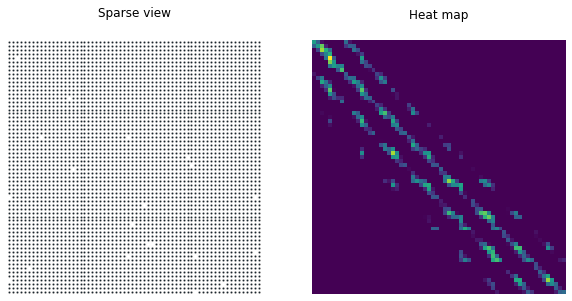

In [28]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

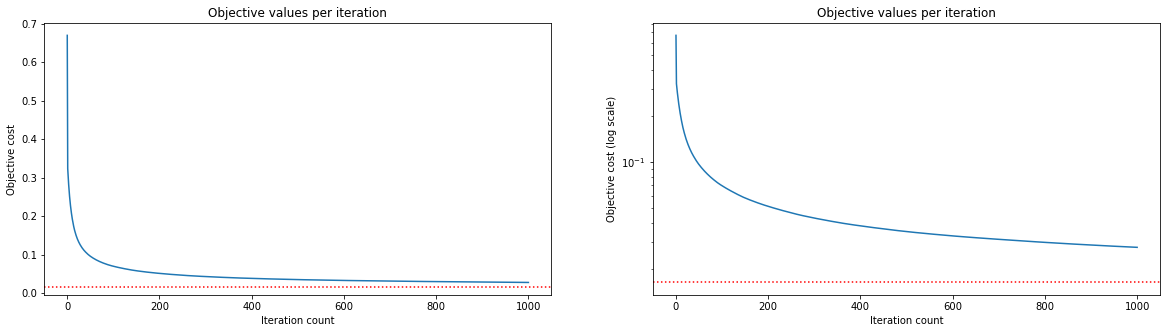

In [29]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost');    plt.title('Objective values per iteration')
plt.subplot(1, 2, 2)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')

plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

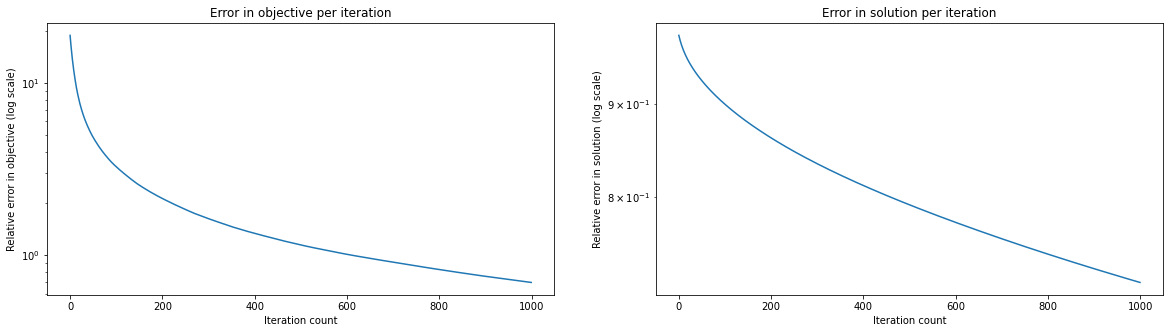

In [30]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')

plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

All the data from the above two plots is also available as dataframes:

In [31]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x
0,612,0.032535,1.0,0.999465,4.003585,0.773162


\begin{tabular}{rrrrrr}
\toprule
 it &      obj &  tol &  dist\_obj &     time &   dist\_x \\
\midrule
612 & 0.032535 &  1.0 &  0.999465 & 4.003585 & 0.773162 \\
\bottomrule
\end{tabular}



In [32]:
df_every = pd.DataFrame.from_dict(every_iter)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x
0,0,0.323401,18.874936,0.027072,0.980743
1,1,0.301216,17.511538,0.105547,0.978410
2,2,0.282688,16.372868,0.134714,0.976227
3,3,0.266216,15.360572,0.163687,0.974178
4,4,0.251503,14.456359,0.189661,0.972248


In [33]:
df_every.describe()

,it,obj,dist_obj,time,dist_x
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,0.045167,1.775784,3.452294,0.804903
std,288.819436,0.030780,1.891601,1.155708,0.063166
min,0.000000,0.027596,0.695953,0.027072,0.718804
25%,249.750000,0.030402,0.868398,2.802072,0.752033
50%,499.500000,0.034966,1.148859,3.714510,0.792551
75%,749.250000,0.046290,1.844796,4.329037,0.847531
max,999.000000,0.323401,18.874936,5.028458,0.980743


In [34]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

In [35]:
# Aliases
#from numpy import log, ceil, inf, absolute, tensordot, sqrt, array
#from numpy.linalg import norm